### TYK2 DMS/FlowDMS Quantitative Contrasts

  1.  [Error Propagation: FlowDMS](#part1)
  2.  [Error Propagation: DMS](#part2)
  3.  [Global Summary Statistics](#part3)
  4.  [Positional Distributions](#part4)

In [28]:
library(ggbeeswarm)
library(ggpubr)
library(knitr)
library(scales)
library(ggrepel)
library(scico)
library(furrr)
library(MASS)
library(patchwork)
library(tidyverse)

generate_resamples <- function(mean_vec, se_vec, metadata, num){
    
    df <- mvrnorm(n = num,
                  mu = mean_vec,
                  Sigma = diag(se_vec^2)) %>%
        as_tibble() %>%
        mutate(n = row_number()) %>%
        rename(c("0.125" = "V1", "0.375" = "V2", "0.625" = "V3", "0.875" = "V4")) %>%
        pivot_longer(names_to = "bin", values_to = "value", `0.125`:`0.875`)

    df_score <- df %>%
        group_by(n) %>% 
        mutate(bin = as.numeric(bin),
               value = (value - min(value)) / sum(value - min(value))) %>%
        summarize(score = sum(bin*value)) 
    
    return(bind_cols(tibble("score_mean" = mean(df_score$score), "score_se" = sd(df_score$score)),
                     metadata))
    
}

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, reverse = TRUE ,palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

#### Error Propagation: FlowDMS <a name="part1"></a>

We start by finding the FlowDMS midpoints for chunks 3, 10, and 14 while propagating the per-bin errors. As before, we can extract the WT score estimate and standard error, with a separate estimate per chunk. The estimates for all three chunks are extremely similar, and the full midpoint summary statistics for the mini-FlowDMS are located [here](../sumstats/TYK2-VAMP/midpoint/).

In [2]:
dms <- read_tsv("../sumstats/TYK2/run7/tyk2-assay7.tsv") %>%
    filter(condition == "IFNalpha100_0 - None_0", chunk %in% c(3, 10, 14)) %>%
    dplyr::select(chunk, pos, aa, estimate, std.error, statistic, p.value, p.adj) %>%
    mutate(fc = 2^estimate)

flowdms <- read_tsv(c("../sumstats/TYK2-VAMP/midpoint/tyk2-vamp-mini_3-vampseq.sumstats.tsv",
                      "../sumstats/TYK2-VAMP/midpoint/tyk2-vamp-mini_10-vampseq.sumstats.tsv",
                      "../sumstats/TYK2-VAMP/midpoint/tyk2-vamp-mini_14-vampseq.sumstats.tsv"))
marginals <- flowdms %>% filter(is.na(term))
coefs <- flowdms %>% filter(!is.na(term))

weights <- marginals %>%
    dplyr::select(condition_conc, chunk, pos, mut_aa, estimate, std.error) %>%
    rename("bin" = "condition_conc") %>%
    group_by(chunk, pos, mut_aa) %>%
    mutate(std.error = std.error / sqrt(sum(estimate - min(estimate))),
           estimate = (estimate - min(estimate))/sum(estimate - min(estimate)),
           bin = case_when(bin == 25 ~ 0.125,
                           bin == 50 ~ 0.375,
                           bin == 75 ~ 0.625,
                           TRUE ~ 0.875))

Rows: 94876 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): drug, clone, chunk, aa, version, condition
dbl (8): conc, pos, estimate, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 35482 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): effect, component, group, term, mut_aa, version
dbl (9): chunk, pos, estimate, std.error, statistic, p.value, dispersion, co...
lgl (1): clone

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# this cell takes a few minutes to run
sample_stats <- weights %>% 
    group_by(chunk, pos, mut_aa) %>% 
    group_map(~generate_resamples(.x$estimate, .x$std.error, .y, num = 1000)) %>%
    bind_rows()

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if
`.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.”


In [4]:
wt_scores <- sample_stats %>%
    filter(mut_aa == "WT") %>% 
    group_by(chunk) %>%
    summarize("WT score" = median(score_mean),
              "WT score standard error" = median(score_se))

wt_scores %>% kable("markdown")



| chunk|  WT score| WT score standard error|
|-----:|---------:|-----------------------:|
|     3| 0.7037447|               0.0106709|
|    10| 0.6756306|               0.0058669|
|    14| 0.6874737|               0.0074624|

In [5]:
sample_stats_test <- sample_stats %>%
    filter(mut_aa != "WT") %>%
    left_join(wt_scores, by = "chunk") %>%
    mutate(estimate = score_mean - `WT score`,
           std.error = sqrt(score_se^2 + `WT score standard error`^2),
           statistic = estimate/std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

sample_stats_test %>%
    write_tsv("../sumstats/TYK2-VAMP/midpoint/vamp-3-10-14-midpoint-sumstats.tsv")

Next, we apply the transformation described in the [TYK2 calibration notebook](../TYK2-Calibration.md), where we use the median stop effect computed _within_ each chunk as with WT:

$$ Score = \frac{midpoint - median(stop)}{median(WT) - median(stop)} $$

We get the same median scores and standard errors for the set of stop effect per chunk:

In [6]:
stop_scores <- sample_stats %>%
    filter(mut_aa == "*") %>%
    group_by(chunk) %>%
    summarize("Stop score" = median(score_mean),
              "Stop score standard error" = median(score_se))

stop_scores %>% kable("markdown")



| chunk| Stop score| Stop score standard error|
|-----:|----------:|-------------------------:|
|     3|  0.2794127|                 0.0631790|
|    10|  0.2995426|                 0.0477065|
|    14|  0.3199645|                 0.0527895|

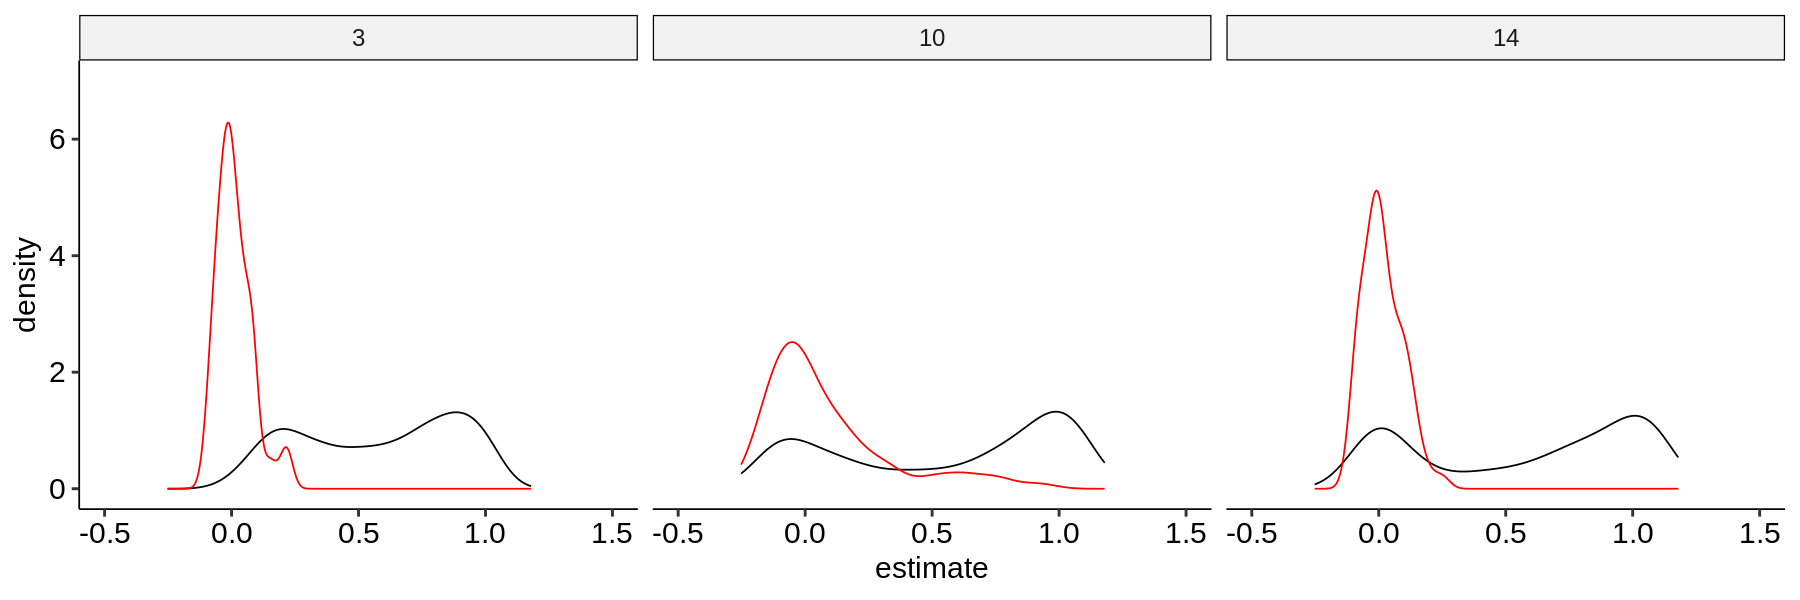

In [7]:
sample_stats_rescale <- sample_stats %>%
    filter(mut_aa != "WT") %>%
    left_join(wt_scores, by = "chunk") %>%
    left_join(stop_scores, by = "chunk") %>%
    mutate(estimate = (score_mean - `Stop score`)/(`WT score` - `Stop score`),
           std.error = score_se/(`WT score` - `Stop score`))

options(repr.plot.width = 15, repr.plot.height = 5)
sample_stats_rescale %>%
    ggplot() +
        geom_density(aes(x = estimate, color = if_else(mut_aa == "*", "red", "black"))) +
        facet_wrap(~chunk, nrow = 1) +
        scale_color_identity() +
        theme_pubr(base_size = 18) +
        coord_cartesian(xlim = c(-0.5,1.5),
                        ylim = c(0,7))

#### Error Propagation: DMS <a name="part2"></a>

Next, we transform the DMS summary statistics to the same scale and propagate the error with the following transformation:

$$ FC = 2^{Log2FoldChange} $$

$$ Score = \frac{FC - median(FC_{stop})}{1 - median(FC_{stop})} $$

As before, the subtraction and division steps are straightforward to propagate error through. However, the exponentiation involved in going from Log2FoldChange to FoldChange results in asymmetric confidence intervals and thus is not as simple but do-able by sampling. We can make an analogous distribution of stop effects as above on the new scale. Immediately, it is obvious that the range of each distribution is much wider than that of FlowDMS, which seems intuitive given the necessary FlowDMS binning:



|chunk | median(FCstop)|
|:-----|--------------:|
|3     |      0.3266600|
|10    |      0.3131436|
|14    |      0.3187060|

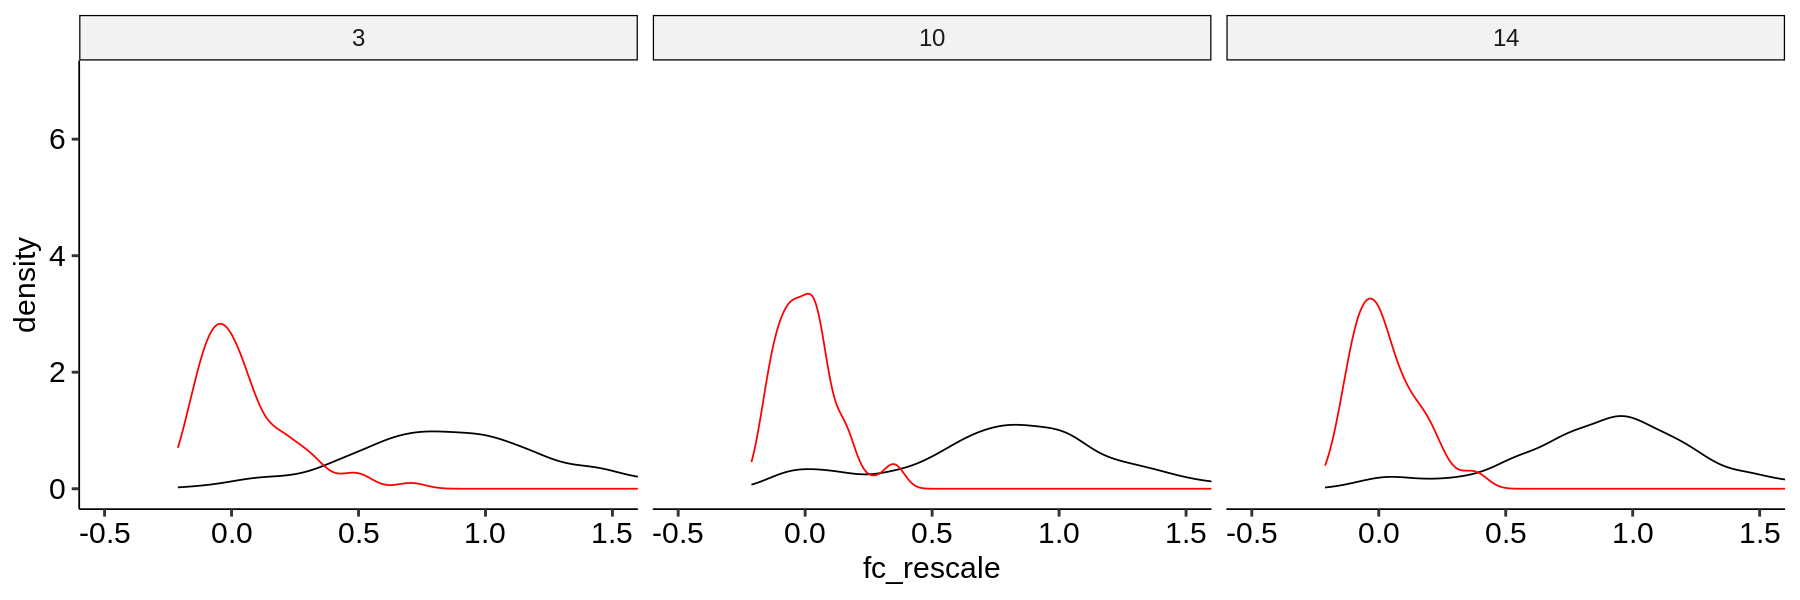

In [8]:
stop_scores_dms <- dms %>%
    filter(aa == "*") %>% 
    group_by(chunk) %>%
    summarize(stop_med = median(fc))

stop_scores_dms %>%
    arrange(as.numeric(chunk)) %>%
    rename("median(FCstop)" = "stop_med") %>%
    kable("markdown")

dms_rescale <- dms %>%
    left_join(stop_scores_dms, by = "chunk") %>%
    mutate(fc_rescale = (fc - stop_med)/(1 - stop_med))

ggplot(dms_rescale) +
        geom_density(aes(x = fc_rescale, color = if_else(aa == "*", "red", "black"))) +
        facet_wrap(~reorder(chunk, as.numeric(chunk)), nrow = 1) +
        scale_color_identity() +
        theme_pubr(base_size = 18)  +
        coord_cartesian(xlim = c(-0.5,1.5),
                        ylim = c(0,7))

#### Global Summary Statistics <a name="part3"></a>

Now, we want to characterize the difference between these two rescaled values across each assay. To evaluate this, we sample and transform the DMS summary statistics, including exponentiation, and compare it to an analogous sampling from the FlowDMS summary statistics. To do so, we sample "effects" from our summary statistics using the distributions:

$$ DMS:\ Normal(Log2FoldChange, Log2StandardError) $$

$$ FlowDMS:\ Normal(Midpoint, MidpointSE) $$

We sample from these distributions many times, perform the rescaling operations on each resampled point, and then obtain the resulting distributions after any transformations. The mean and standard deviation of this distribution (a _sampling distribution_) are our transformed estimates and standard errors, respectively. We can see what this looks like with an individual spike-in from chunk 10 (669P):

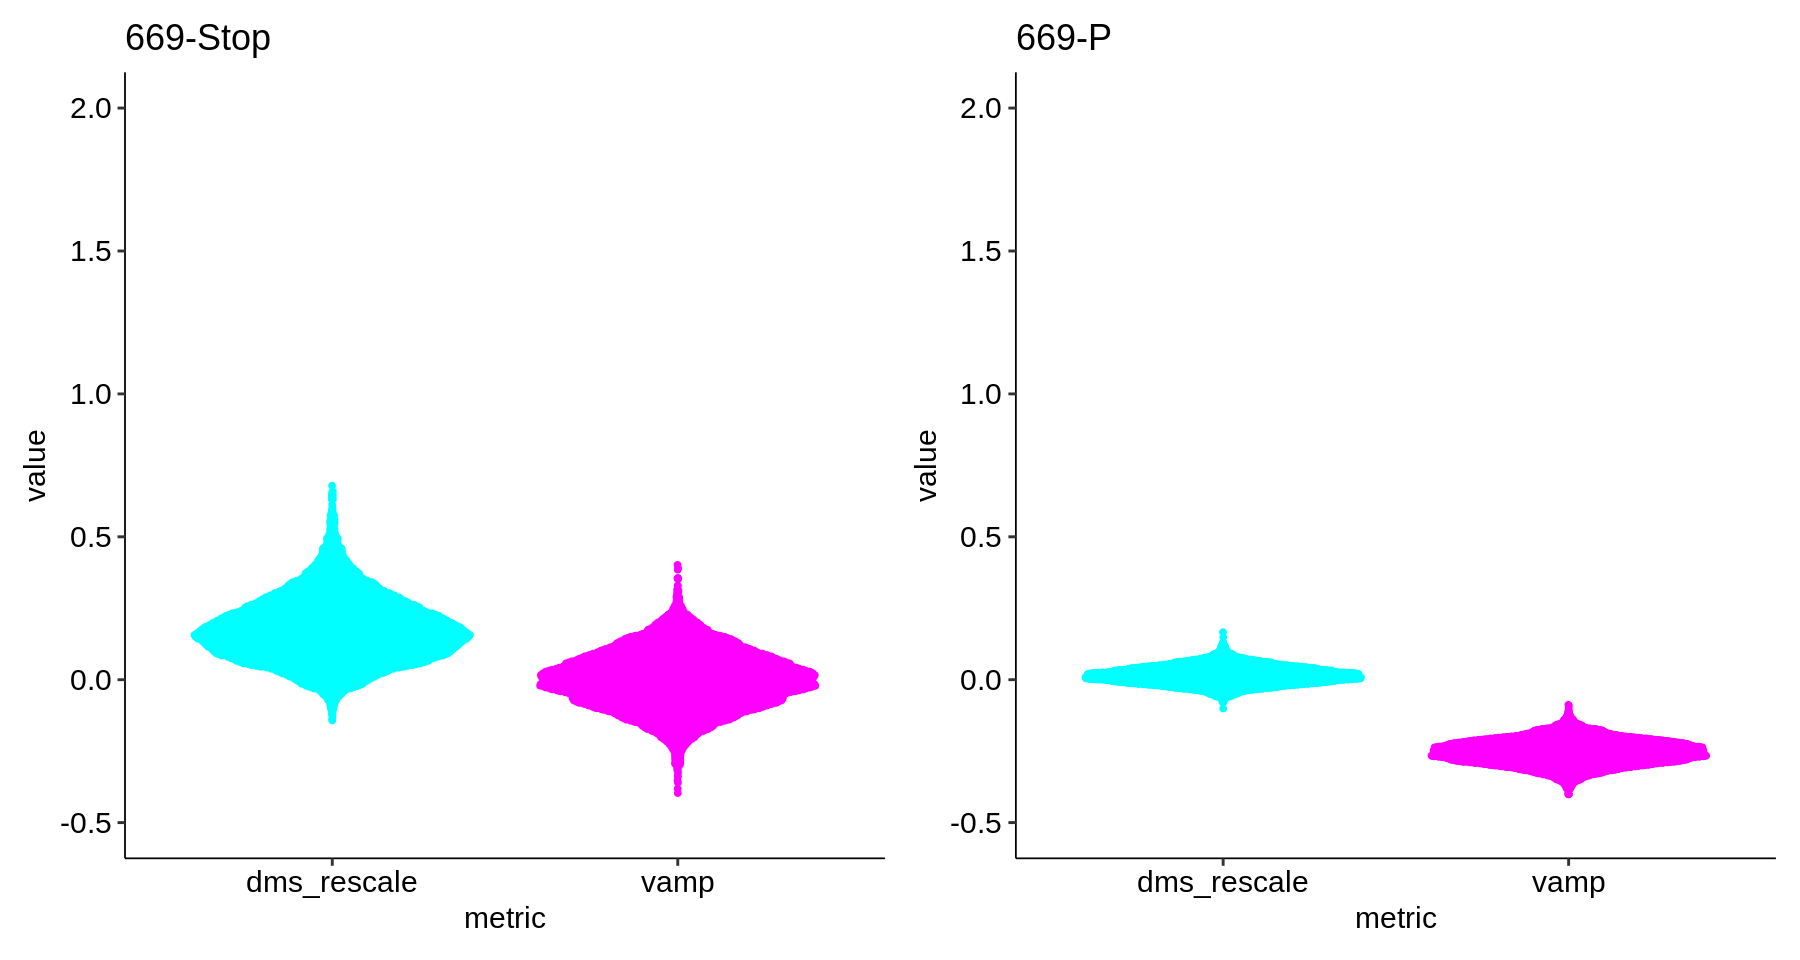

In [9]:
dms_stat <- dms_rescale %>% filter(pos == 669, aa == "*") %>% dplyr::select(chunk, pos, aa, estimate, std.error, fc, stop_med, fc_rescale)
vamp_stat <- sample_stats_rescale %>% filter(pos == 669, mut_aa == "*")  %>% dplyr::select(chunk, pos, mut_aa, estimate, std.error)

pos_resamp <- tibble("dms" = rnorm(mean = dms_stat$estimate, sd = dms_stat$std.error, n = 10000),
                      "vamp" = rnorm(mean = vamp_stat$estimate, sd = vamp_stat$std.error, n = 10000)) %>%
    mutate(dms_rescale = ((2^dms) - unlist(stop_scores[2,2]) ) / (1 - unlist(stop_scores[2,2])),
           id = row_number()) 

p1 <- pos_resamp %>%
    dplyr::select(-dms) %>%
    pivot_longer(names_to = "metric", values_to = "value", vamp:dms_rescale) %>%
    ggplot() +
        geom_quasirandom(aes(y = value, x = metric, color = if_else(metric == "vamp", "magenta", "cyan"))) +
        theme_pubr(base_size = 18) +
        scale_color_identity() +
        coord_cartesian(ylim = c(-0.5, 2)) +
        ggtitle("669-Stop")

dms_stat <- dms_rescale %>% filter(pos == 669, aa == "P") %>% dplyr::select(chunk, pos, aa, estimate, std.error, fc, stop_med, fc_rescale)
vamp_stat <- sample_stats_rescale %>% filter(pos == 669, mut_aa == "P")  %>% dplyr::select(chunk, pos, mut_aa, estimate, std.error)

pos_resamp <- tibble("dms" = rnorm(mean = dms_stat$estimate, sd = dms_stat$std.error, n = 10000),
                      "vamp" = rnorm(mean = vamp_stat$estimate, sd = vamp_stat$std.error, n = 10000)) %>%
    mutate(dms_rescale = ((2^dms) - unlist(stop_scores[2,2]) ) / (1 - unlist(stop_scores[2,2])),
           id = row_number()) 

p2 <- pos_resamp %>%
    dplyr::select(-dms) %>%
    pivot_longer(names_to = "metric", values_to = "value", vamp:dms_rescale) %>%
    ggplot() +
        geom_quasirandom(aes(y = value, x = metric, color = if_else(metric == "vamp", "magenta", "cyan"))) +
        theme_pubr(base_size = 18) +
        scale_color_identity() +
        coord_cartesian(ylim = c(-0.5, 2)) +
        ggtitle("669-P")

options(repr.plot.width = 15, repr.plot.height = 8)
p1 + p2

We can test the extent of overlap between the two distributions for each variant by approximating each as normal, or simply using an empirical FDR. Here, we use the pooled standard error to test for a non-zero mean difference with a Wald test. The first facet plot below shows the 0-1 scale estimates for each assay type, with Stops highlighted. The second facet plot shows the same, except with significant (FDR < 1%) cross-assay contrasts highlighted:

In [10]:
dms_stat <- dms_rescale %>% dplyr::select(chunk, pos, aa, estimate, std.error, fc, stop_med, fc_rescale) %>%
    rename("estimate_dms" = "estimate",
           "std.error_dms" = "std.error") %>%
    mutate(chunk = as.numeric(chunk))
vamp_stat <- sample_stats_rescale %>% dplyr::select(chunk, pos, mut_aa, estimate, std.error) %>%
    rename("estimate_flow" = "estimate",
           "std.error_flow" = "std.error")

combined_stat <- inner_join(dms_stat, vamp_stat, by = c("chunk", "pos", "aa" = "mut_aa"))

In [14]:
compute_overlap <- function(est_dms, se_dms, est_flow, se_flow, stop_med){

    resamped <- tibble("dms" = rnorm(mean = est_dms, sd = se_dms, n = 1000)) %>%
        mutate(dms_rescale = ((2^dms) - stop_med ) / (1 - stop_med)) %>%
        summarize(estimate_dms = mean(dms_rescale),
                  std.error_dms = sd(dms_rescale),
                  estimate_flow = est_flow,
                  std.error_flow = se_flow) %>%
        mutate(z = (estimate_dms - estimate_flow) / sqrt(std.error_dms^2 + std.error_flow^2),
               p.value = pmin(pnorm(z, mean = 0, sd = 1)*2,
                              (1-pnorm(z, sd = 1))*2),
               p.adj = p.adjust(p.value, method = "BH"))

    return(resamped)
}

plan(multicore, workers = 40)
contrast_stats <- future_pmap_dfr(combined_stat,
                     ~compute_overlap(est_dms = ..4,
                                      se_dms = ..5,
                                      est_flow = ..9,
                                      se_flow = ..10,
                                      stop_med = ..7),
                     .options = furrr_options(seed = TRUE)) %>%
    bind_cols(combined_stat[,1:3])

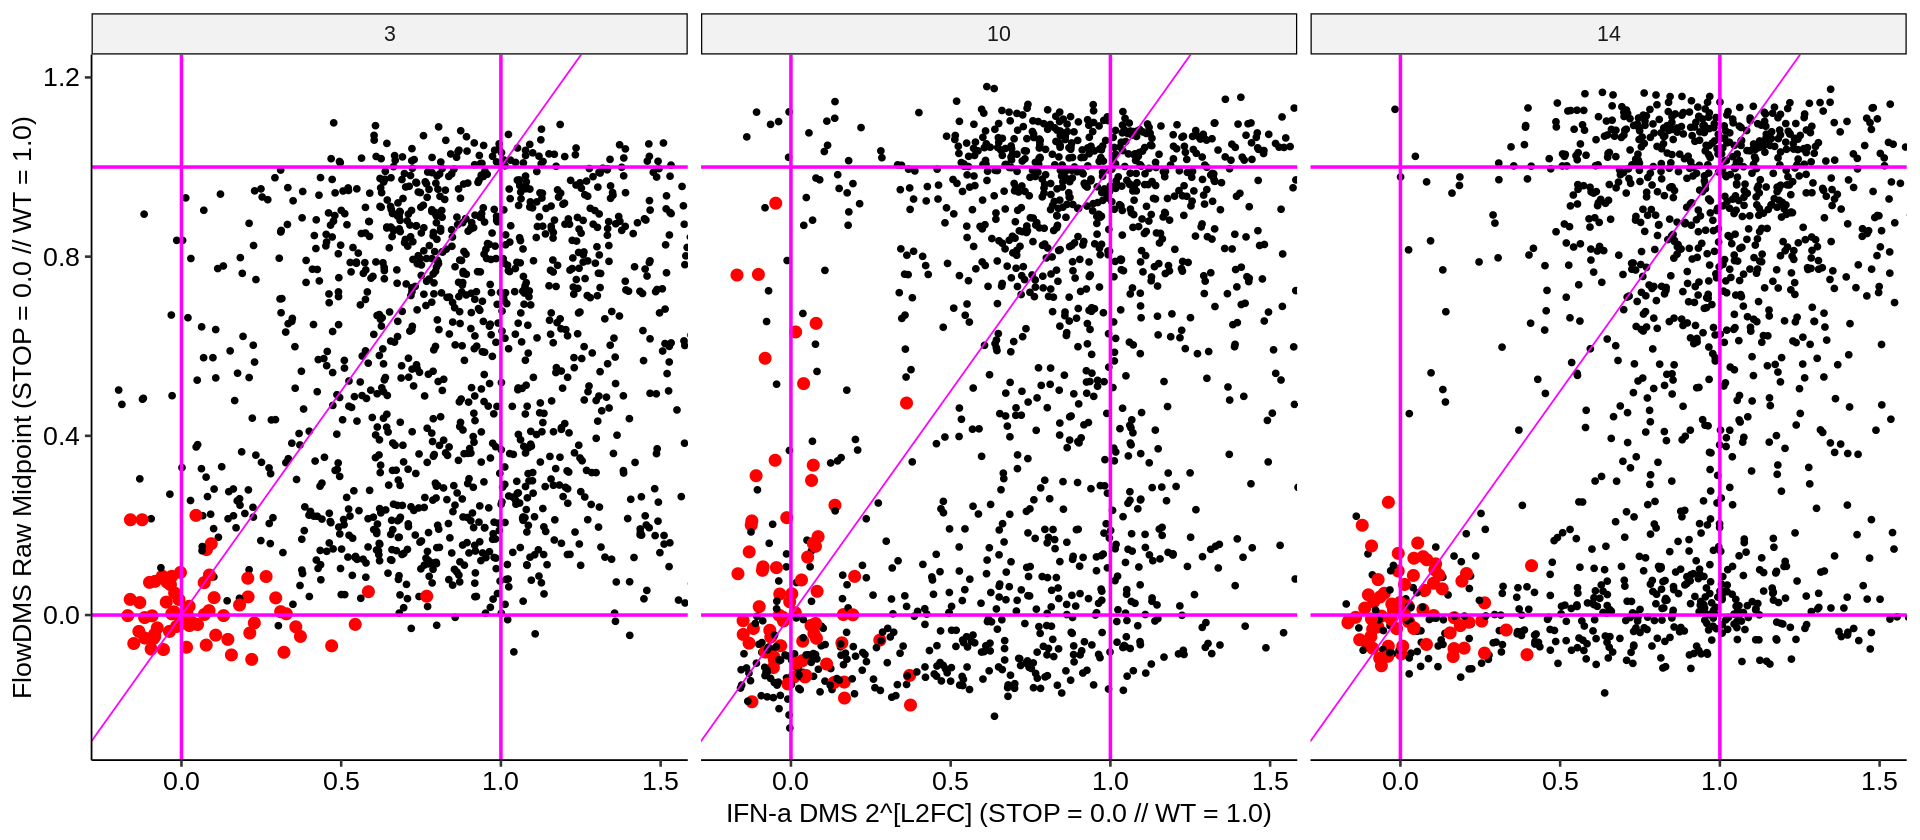

In [15]:
options(repr.plot.width = 16, repr.plot.height = 7)
ggplot(contrast_stats) +
    geom_point(aes(x = estimate_dms,
                   y = estimate_flow,
                   color = if_else(aa == "*" , "red", "black"),
                   size = if_else(aa == "*", 3, 1.5))) +
    theme_pubr(base_size = 16) +
    scale_color_identity() +
    scale_size_identity() +
    xlab("IFN-a DMS 2^[L2FC] (STOP = 0.0 // WT = 1.0)") +
    ylab("FlowDMS Raw Midpoint (STOP = 0.0 // WT = 1.0)") +
    coord_cartesian(xlim = c(NA, 1.5)) +
    facet_wrap(~chunk, nrow = 1) +
    geom_hline(yintercept = c(1, 0), color = "magenta", linewidth = 1) +
    geom_vline(xintercept = c(1, 0), color = "magenta", linewidth = 1) +
    geom_abline(slope = 1, intercept = 0, color = "magenta")

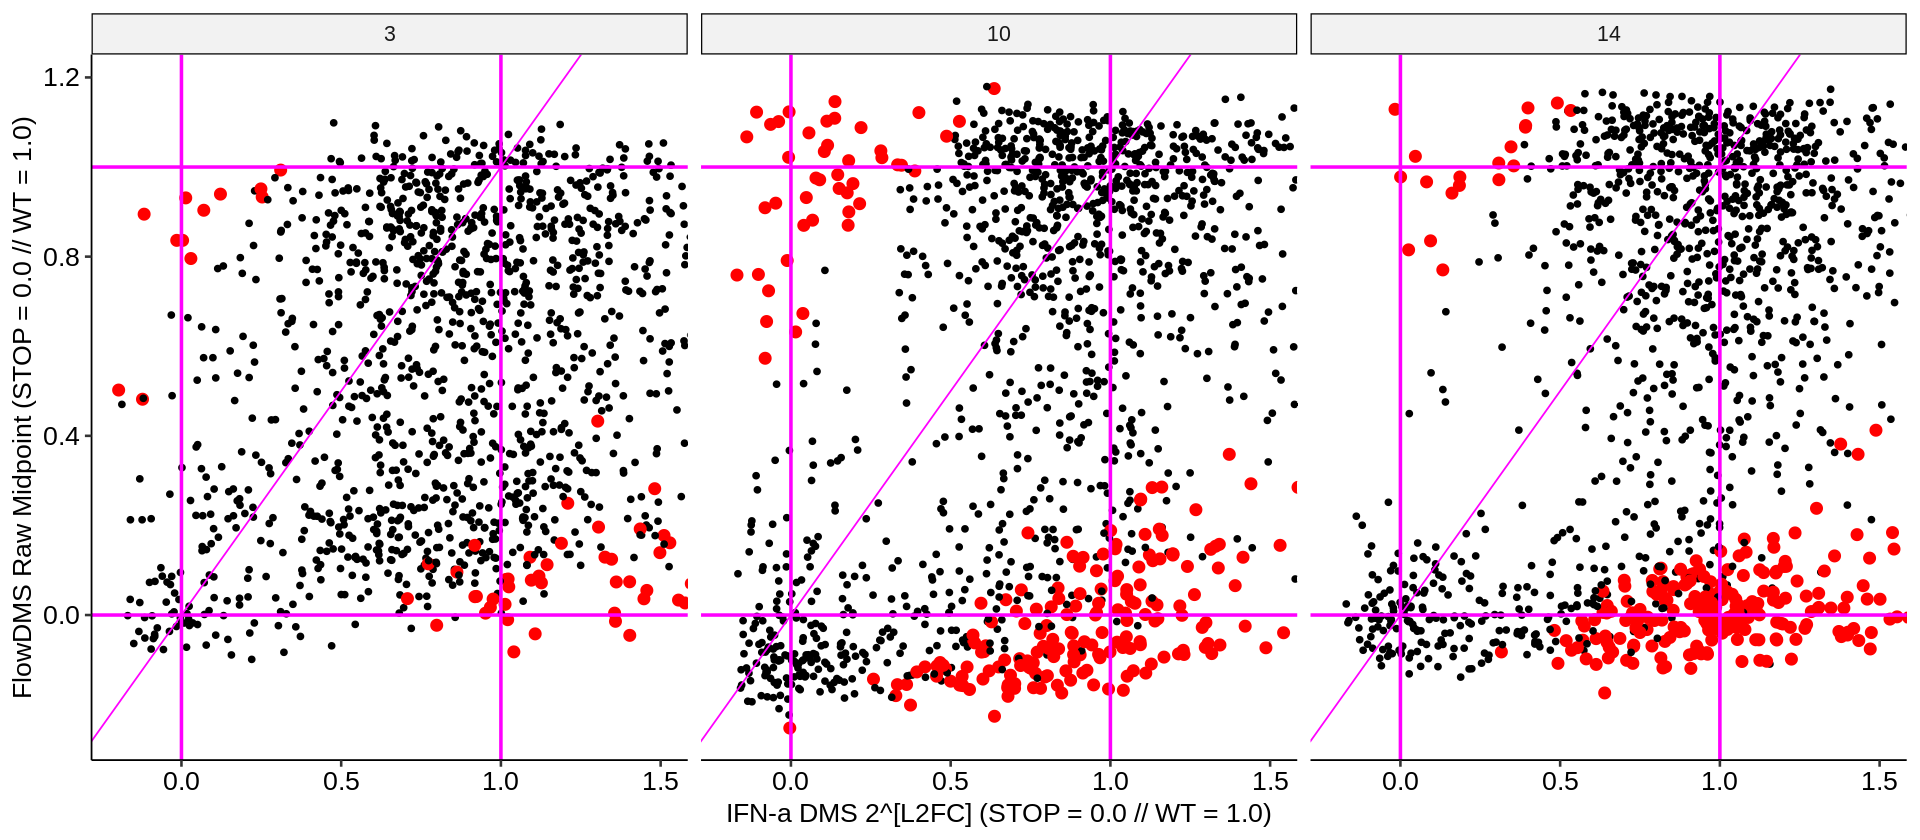

In [16]:
options(repr.plot.width = 16, repr.plot.height = 7)
ggplot(contrast_stats) +
    geom_point(aes(x = estimate_dms,
                   y = estimate_flow,
                   color = if_else(p.adj < 0.01 , "red", "black"),
                   size = if_else(p.adj < 0.01, 3, 1.5))) +
    theme_pubr(base_size = 16) +
    scale_color_identity() +
    scale_size_identity() +
    xlab("IFN-a DMS 2^[L2FC] (STOP = 0.0 // WT = 1.0)") +
    ylab("FlowDMS Raw Midpoint (STOP = 0.0 // WT = 1.0)") +
    coord_cartesian(xlim = c(NA, 1.5)) +
    facet_wrap(~chunk, nrow = 1) +
    geom_hline(yintercept = c(1, 0), color = "magenta", linewidth = 1) +
    geom_vline(xintercept = c(1, 0), color = "magenta", linewidth = 1) +
    geom_abline(slope = 1, intercept = 0, color = "magenta")

In [75]:
contrast_stats %>%
    write_tsv("../sumstats/TYK2-VAMP/midpoint/DMS-flowDMS-rescaled.tsv")

#### Positional Distributions <a name="part4"></a>
We can use these tests to identify the variants that are significantly LoF by signaling by with little protein stability effect. These are the red points in the lower facet plots above that are in the upper left quadrant:

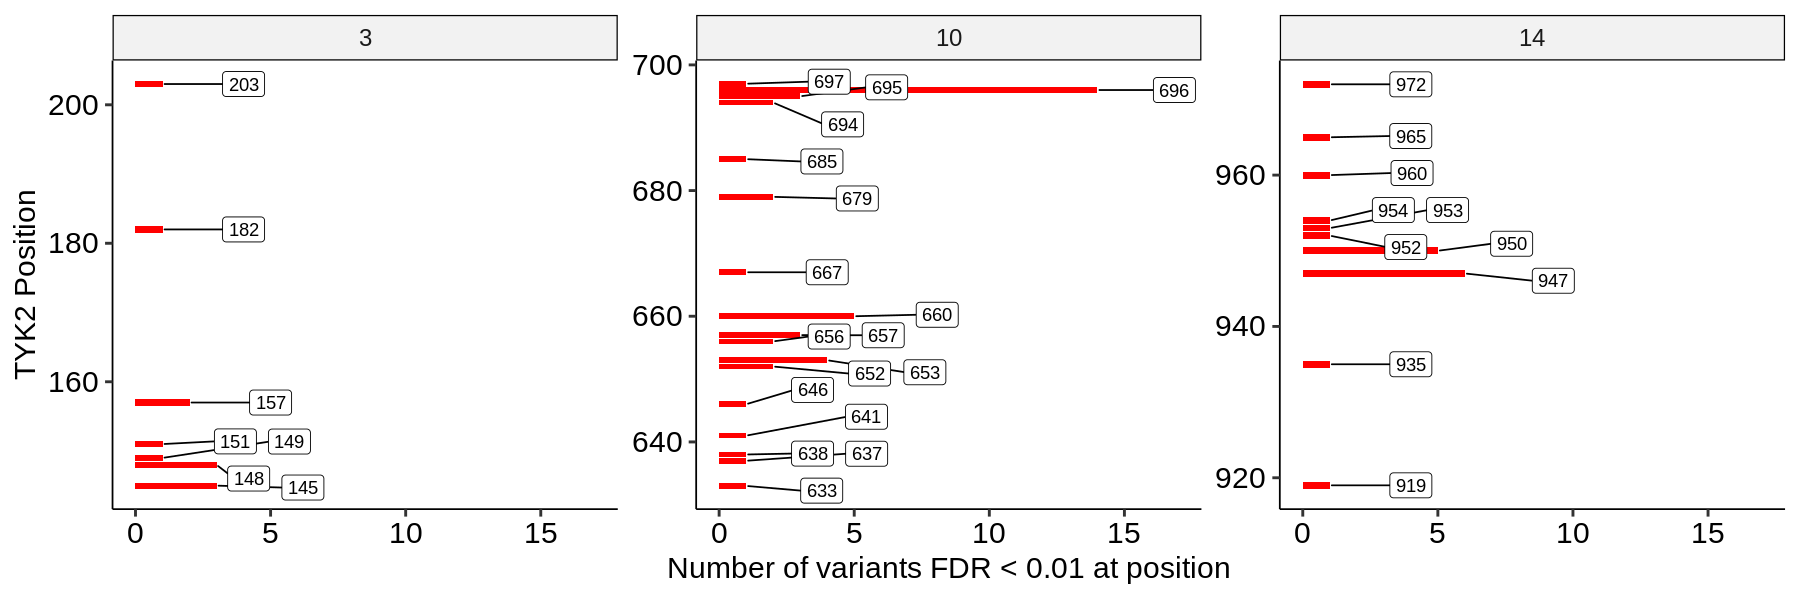

In [20]:
options(repr.plot.width = 15, repr.plot.height = 5)
contrast_stats %>%
    filter(z < 0, p.adj < 0.01) %>%
    dplyr::select(chunk, pos, aa) %>%
    count(chunk, pos, .drop = FALSE) %>%
    ggplot() +
        geom_bar(aes(x = pos, y = n), stat = "identity", fill = "red") +
        geom_label_repel(aes(x = pos, y = n, label = pos), stat = "identity", nudge_y = 3) +
        facet_wrap(~chunk, scales = "free_y", ncol = 3) +
        theme_pubr(base_size = 18) +
        scale_fill_identity() +
        coord_flip() +
        xlab("TYK2 Position") + ylab("Number of variants FDR < 0.01 at position")

Similarly, we can make heatmaps of specifically the contrast:

In [70]:
compute_overlap_thresh <- function(est_dms, se_dms, est_flow, se_flow, stop_med, null_thresh){

    resamped <- tibble("dms" = rnorm(mean = est_dms, sd = se_dms, n = 1000)) %>%
        mutate(dms_rescale = ((2^dms) - stop_med ) / (1 - stop_med)) %>%
        summarize(estimate_dms = mean(dms_rescale),
                  std.error_dms = sd(dms_rescale),
                  estimate_flow = est_flow,
                  std.error_flow = se_flow) %>%
        mutate(z = (estimate_flow - estimate_dms - null_thresh) / sqrt(std.error_dms^2 + std.error_flow^2),
               p.value = 1-pnorm(z, sd = 1),
               p.adj = p.adjust(p.value, method = "BH"),
               p.adj = if_else(p.adj == 0, 2.2e-16, p.adj))

    return(resamped)
}

plot_heatmap_thresh <- function(thresh, sumstats){

    contrast_stats_thresh <- future_pmap_dfr(sumstats,
                     ~compute_overlap_thresh(est_dms = ..4,
                                              se_dms = ..5,
                                              est_flow = ..9,
                                              se_flow = ..10,
                                              stop_med = ..7,
                                              null_thresh = thresh),
                     .options = furrr_options(seed = TRUE)) %>%
        bind_cols(sumstats[,1:3])

    heatmap_plot <- contrast_stats_thresh %>%
        mutate(aa = if_else(aa == "*", "Stop", aa)) %>%
        ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = -log10(p.adj))) +
            theme_pubr(base_size = 16) +
            ggtitle(str_c("Null Shift = ", thresh)) +
            xlab("TYK2 Position") + ylab("AA") +
            facet_wrap(~chunk, scales = "free_x") +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish, limits = c(0,20))
    
    return(heatmap_plot)

}



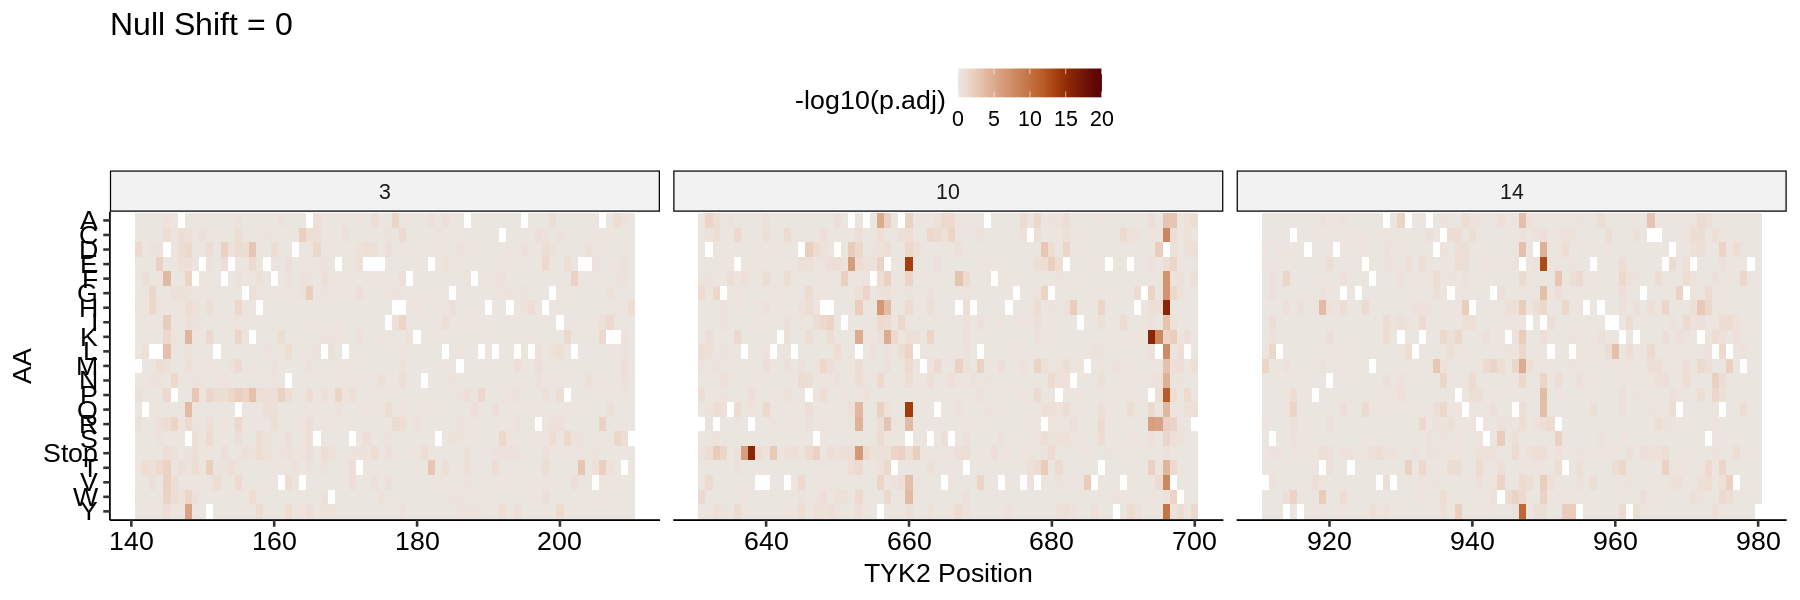

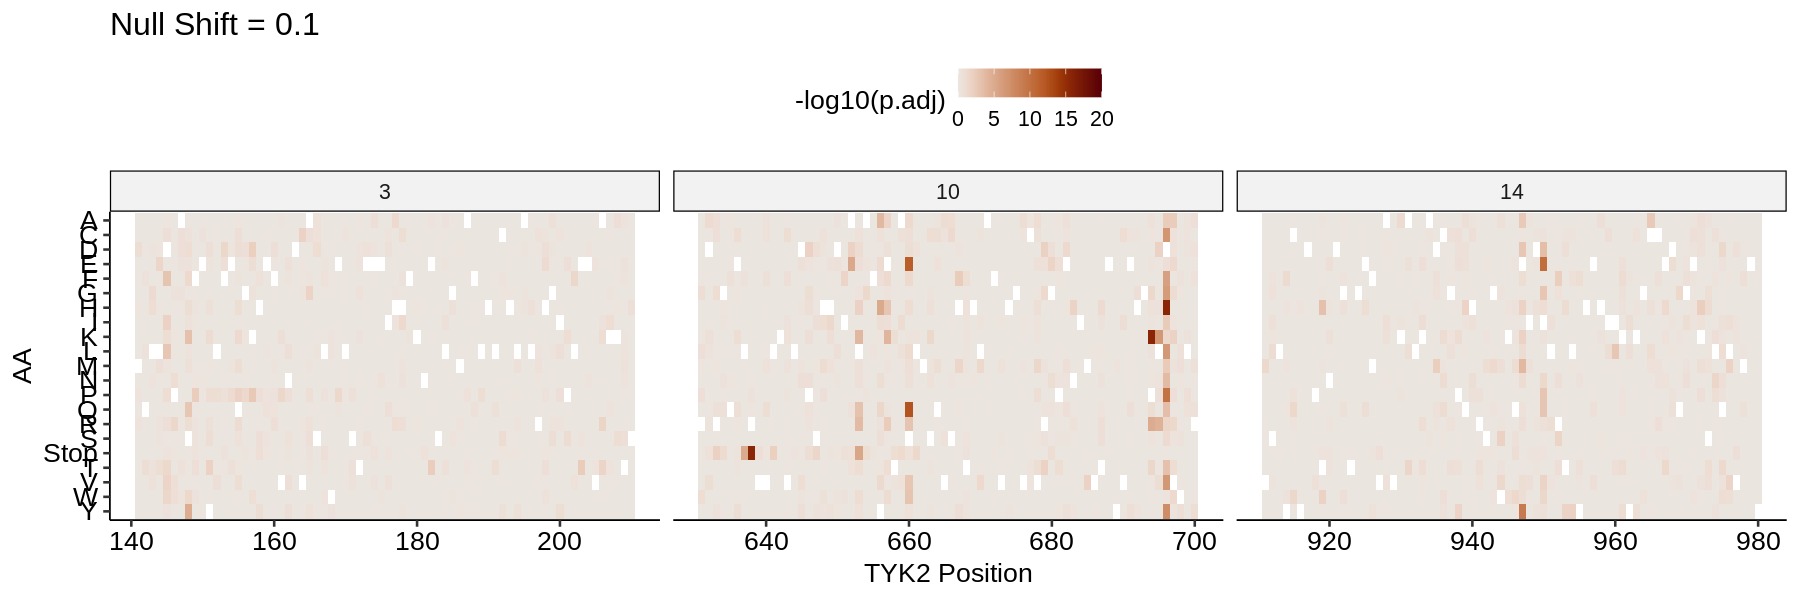

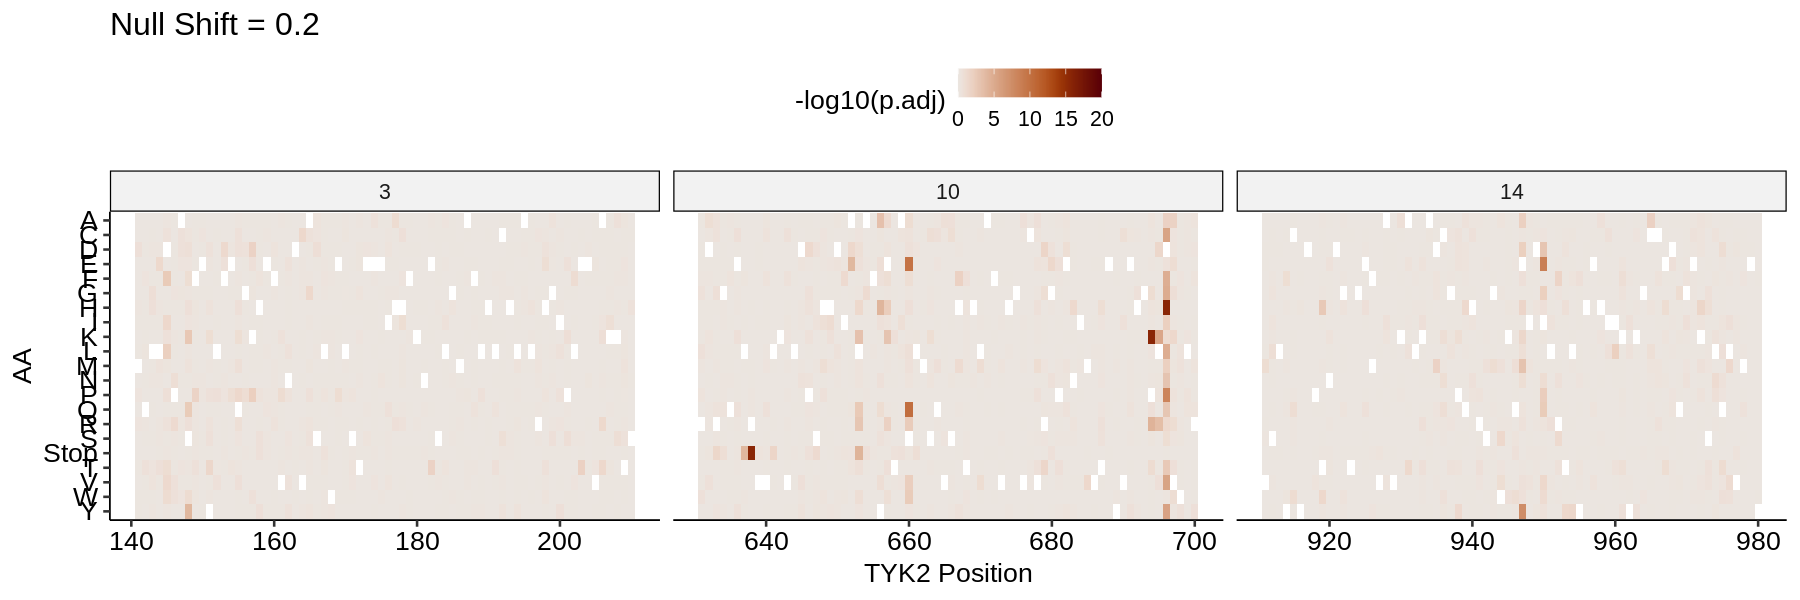

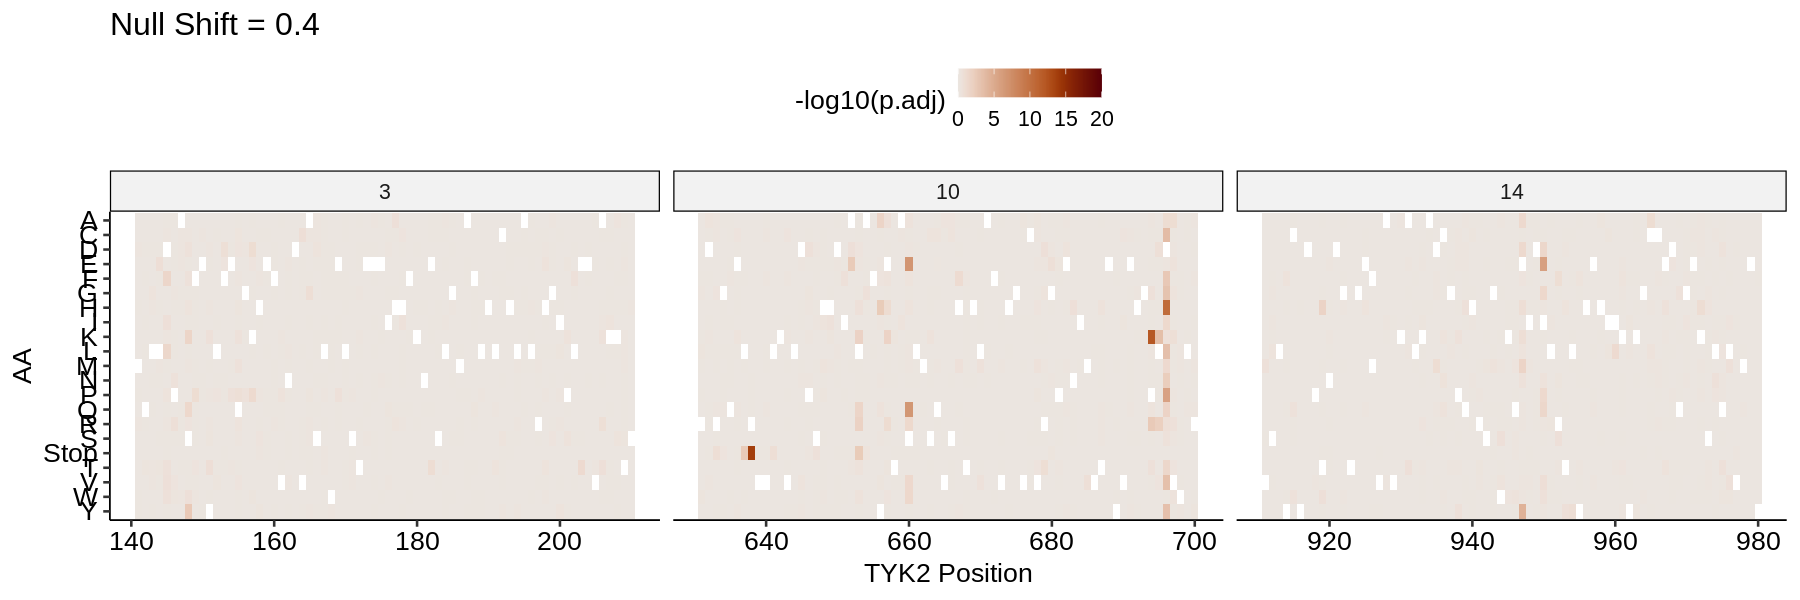

In [73]:
plot_heatmap_thresh(0, combined_stat)
plot_heatmap_thresh(0.1, combined_stat)
plot_heatmap_thresh(0.2, combined_stat)
plot_heatmap_thresh(0.4, combined_stat)